# Importing Libraries

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Loading Dataset

In [20]:
# Load the dataset
data = pd.read_csv('daily_data.csv')

# Display the first few rows
print(data.head())

  day_id city_id  temperature_celsius           condition_text  wind_kph  \
0  D0001    C001                 27.0                      NaN       6.1   
1  D0002    C001                 22.0                      NaN       6.1   
2  D0003    C001                 20.0  Light Rain with Thunder       3.6   
3  D0004    C001                 17.0          Clear and Sunny       6.1   
4  D0005    C001                 18.0                      NaN       3.6   

   wind_degree  pressure_mb  precip_mm  humidity  cloud  feels_like_celsius  \
0          210       1006.0        0.0        54     75                28.0   
1          170       1006.0        0.0        73     75                24.5   
2           10       1011.0        4.5       100     75                20.0   
3          150       1018.0        0.0        88      0                17.0   
4           92       1019.0        0.0        94      0                18.0   

   visibility_km  uv_index  gust_kph  air_quality_us-epa-index   sun

# Data Preprocessing

In [21]:
# Drop rows with missing condition_text
data = data.dropna(subset=['condition_text'])

# Display the shape of the data to see how many rows we have now
print(data.shape)

(479, 17)


In [22]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the condition_text column
data['condition_text'] = label_encoder.fit_transform(data['condition_text'])

# Display the unique classes and their corresponding numerical labels
label_classes = list(label_encoder.classes_)
print("Classes:", label_classes)

Classes: ['Clear and Sunny', 'Cloudy and Overcast', 'Light Precipitation', 'Light Rain with Thunder', 'Mist or Fog', 'Moderate to Heavy Rain', 'Partly Cloudy', 'Rain Showers', 'Thunderstorms']


In [23]:
# List of numerical columns to normalize
numerical_cols = ['temperature_celsius', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm', 'humidity',
                  'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_us-epa-index']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Display the first few rows to see the changes
print(data.head())

   day_id city_id  temperature_celsius  condition_text  wind_kph  wind_degree  \
2   D0003    C001            -0.325687               3 -0.976376    -1.491115   
3   D0004    C001            -0.791186               0 -0.634911    -0.084787   
6   D0007    C001            -0.170521               6 -0.921742     1.522446   
18  D0019    C001            -0.480854               0 -0.976376    -0.948674   
27  D0028    C002            -0.480854               6 -0.976376    -0.757815   

    pressure_mb  precip_mm  humidity     cloud  feels_like_celsius  \
2     -0.345813   3.808121  1.160612  0.802314           -0.442245   
3      0.802218  -0.246614  0.506188 -1.269057           -0.791270   
6      0.310205  -0.246614  1.160612  0.111857           -0.325903   
18     0.638214  -0.246614  0.506188 -1.269057           -0.558586   
27    -0.509818  -0.246614 -0.311842 -0.578600           -0.558586   

    visibility_km  uv_index  gust_kph  air_quality_us-epa-index   sunrise  \
2        0.1875

In [24]:
# Features (all columns except day_id, city_id, and condition_text)
X = data.drop(columns=['day_id', 'city_id', 'condition_text', 'sunrise', 'sunset'])

# Target variable
y = data['condition_text']

# Display the shapes of X and y
X.shape, y.shape

((479, 12), (479,))

In [25]:
# Features (all columns except day_id, city_id, and condition_text)
X = data.drop(columns=['day_id', 'city_id', 'condition_text', 'sunrise', 'sunset'])

# Target variable
y = data['condition_text']

# Display the shapes of X and y
print(X.shape, y.shape)

(479, 12) (479,)


In [26]:
# Apply SMOTE to balance the dataset
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [27]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
# Display the shapes of the resampled and split data
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(768, 12) (330, 12) (768,) (330,)


# Building the Model

In [28]:
# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 10:
        lr = 0.001
    if epoch > 20:
        lr = 0.0005
    if epoch > 30:
        lr = 0.0001
    return lr

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define the model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(len(label_classes), activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               3328      
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)               

# Training the Model

Epoch 1/75
24/24 [==============================] - 3s 27ms/step - loss: 5.5626 - accuracy: 0.2956 - val_loss: 4.9537 - val_accuracy: 0.4394 - lr: 0.0100
Epoch 2/75
24/24 [==============================] - 0s 8ms/step - loss: 4.3245 - accuracy: 0.4297 - val_loss: 3.6696 - val_accuracy: 0.5333 - lr: 0.0100
Epoch 3/75
24/24 [==============================] - 0s 10ms/step - loss: 3.0492 - accuracy: 0.5104 - val_loss: 3.2895 - val_accuracy: 0.2455 - lr: 0.0100
Epoch 4/75
24/24 [==============================] - 0s 10ms/step - loss: 2.5466 - accuracy: 0.5117 - val_loss: 3.0892 - val_accuracy: 0.2061 - lr: 0.0100
Epoch 5/75
24/24 [==============================] - 0s 9ms/step - loss: 2.3300 - accuracy: 0.5221 - val_loss: 2.9911 - val_accuracy: 0.1909 - lr: 0.0100
Epoch 6/75
24/24 [==============================] - 0s 8ms/step - loss: 2.2245 - accuracy: 0.5612 - val_loss: 2.7866 - val_accuracy: 0.3182 - lr: 0.0100
Epoch 7/75
24/24 [==============================] - 0s 5ms/step - loss: 2.1060 

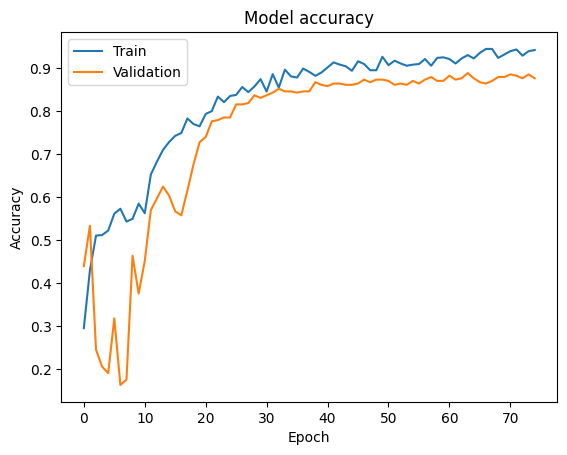

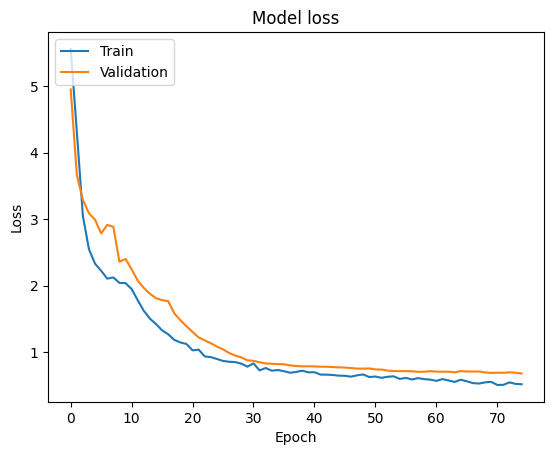

In [29]:
# Train the model with the learning rate scheduler and early stopping
history = model.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_val, y_val), verbose=1,
                    callbacks=[LearningRateScheduler(lr_scheduler), early_stopping])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Prediction and Storing them into Submission file

In [30]:
# Load the submission template
submission = pd.read_csv('submission.csv')

# Load the original dataset
data = pd.read_csv('daily_data.csv')

# List of numerical columns to normalize
numerical_cols = ['temperature_celsius', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm', 'humidity',
                  'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_us-epa-index']

# Merge the submission template with the original data to get features
test_data = pd.merge(submission, data, on='day_id', how='left')

# Drop unnecessary columns
X_test = test_data.drop(columns=['day_id', 'condition_text_x', 'condition_text_y', 'sunrise', 'sunset'])

# Normalize the test data
scaler = StandardScaler()
X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])

# Handle any remaining NaN values in X_test
X_test = X_test.fillna(0)  # Replace NaNs with 0s or any other suitable value

# Drop non-numeric columns if any are left
X_test = X_test.select_dtypes(include=[np.float32, np.float64])  # Select only numeric columns

# Make sure all data is in float32 format
X_test = X_test.astype(np.float32)

# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Decode the predicted labels
label_encoder = LabelEncoder()
label_encoder.fit(data['condition_text'])
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Fill the submission file with predictions
submission['condition_text'] = predicted_labels

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


91/91 [==============================] - 0s 2ms/step
Submission file created successfully!
